In [609]:
import numpy as np
import xarray as xr

import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import glob
import pytz
from scipy.signal import welch, csd
from scipy.stats import chi2

# SAIL EC data

Open and wrangle the raw SAIL EC data

In [610]:
DATE = '20230418'

In [611]:
fast_data_file_path = f"/Users/elischwat/Development/data/sublimationofsnow/sail_fast_ecor_data/gucecorM1.00.{DATE}.000000.raw/**_sonic.raw"
fast_data_files = glob.glob(fast_data_file_path)

In [612]:
def read_and_process_raw_sonic(file):
    high_rate_df = pd.read_csv(file, skiprows=1, header=None).rename(columns = 
    dict(zip(range(0,10), ['Timestamp',
        'u',
        'v',
        'w',
        'windspeed units (M = m/s)',
        'Speed of Sound',
        'Status (00 means okay)',
        'CO2 analog voltage output',
        'H20 analog voltage output',
        'Checksum',]))
    )
    high_rate_df['Timestamp'] = pd.to_datetime(
        f'{DATE} ' + high_rate_df['Timestamp'].str[:-3],
        format="%Y%m%d %H:%M:%S.%f"
    )
    return high_rate_df

In [613]:
df = pd.concat([read_and_process_raw_sonic(f) for f in sorted(fast_data_files)]).reset_index(drop=True)
# df = df.sort_values('Timestamp')
df = df.rename(columns = {'Timestamp': 'time'})

In [614]:
df_means = df.set_index('time').groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean')

In [615]:
df_means['dir'] = np.rad2deg(np.arctan2(-df_means['u'], -df_means['v']))
df_means['dir'] = df_means['dir'].apply(lambda dir: dir if dir >= 0 else dir+360)

<Axes: xlabel='time'>

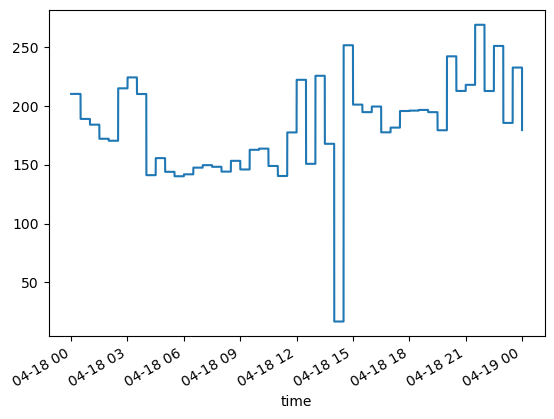

In [616]:
df_means['dir'].plot()

Isolate data to 3 hours between 1500 and 1800, rotate into streamwise coords

In [617]:
df = df.set_index('time').sort_index().loc['20230418 1500': '20230418 1800']

In [618]:
mean_u = df['u'].mean()
mean_v = df['v'].mean()
theta = np.arctan2(mean_v, mean_u)
adj_u = df['u']*np.cos(theta) + df['v']*np.sin(theta)
adj_v = -df['u']*np.sin(theta) + df['v']*np.cos(theta)
df['u'] = adj_u
df['v'] = adj_v

Calculate MRD

In [619]:
def newmrd(data_a, data_b, M, Mx):
    D = np.zeros(M - Mx)
    Dstd = np.copy(D)
    data_a2 = np.copy(data_a)
    data_b2 = np.copy(data_b)
    for ims in range(M - Mx + 1):
        ms = M - ims
        l = 2 ** ms
        nw = round((2 ** M) / l)
        wmeans_a = np.zeros(nw)
        wmeans_b = np.copy(wmeans_a)
        for i in range(nw):
            k = round(i * l)
            wmeans_a[i] = np.mean(data_a2[k:(i+1)*l])
            wmeans_b[i] = np.mean(data_b2[k:(i+1)*l])
            data_a2[k:(i+1)*l] -= wmeans_a[i]
            data_b2[k:(i+1)*l] -= wmeans_b[i]
        if nw > 1:
            D[ms] = np.mean(wmeans_a * wmeans_b)
            Dstd[ms] = np.std(wmeans_a * wmeans_b, ddof=0)
    return D, Dstd

# def calculate_mrd_for_df(df, VAR1, VAR2):
#     M = int(np.floor(np.log2(len(df))))
#     print(f"Got data of length {len(df)}. using M = {M}")
#     timestep = (
#         df['time'].iloc[1] - df['time'].iloc[0]
#     ).total_seconds() * 1000
#     print(f"Timestep of fast data is: {timestep}")
#     mrd_x = np.array([
#         dt.timedelta(milliseconds=2**i * timestep).total_seconds() 
#         for i in range(1, M+1)
#     ])
#     result = newmrd(
#         df[VAR1], 
#         df[VAR2],
#         M, 
#         0
#     )
#     return pd.DataFrame({
#         'tau':      mrd_x,
#         'Co':       result[0],
#         'std':      result[1]
#     })

def calculate_mrd_for_df(df, VAR1, VAR2, shift = 1000):
    M = int(np.floor(np.log2(len(df))))
    print(f"Got data of length {len(df)}. using M = {M}")
    timestep = (
        df['time'].iloc[1] - df['time'].iloc[0]
    ).total_seconds() * 1000
    print(f"Timestep of fast data is: {timestep} ms")
    mrd_x = np.array([
        dt.timedelta(milliseconds=2**i * timestep).total_seconds() 
        for i in range(1, M+1)
    ])
    # initalize the dataframe that we will iteratively remove chunks from 
    current_df = df.copy()
    shift_iter = 0
    result_list = []
    print(f"Original data size: {len(current_df)}")
    while len(current_df) > 2**M:
        print(f"Iteration {shift_iter}, data size: {len(current_df)}")
        result = newmrd(
            current_df[VAR1],
            current_df[VAR2],
            M, 
            0
        )
        current_df = current_df.loc[shift_iter*shift:]
        shift_iter += 1
        result_list.append(
            pd.DataFrame({
                'tau':       mrd_x,
                'Co':        result[0],
                'std':       result[1],
                'iteration': shift_iter
            })
        )
    return pd.concat(result_list)

In [620]:
mrd_uw = calculate_mrd_for_df(
        df.reset_index(), 
        'u', 
        'w'
    )   
mrd_vw = calculate_mrd_for_df(
        df.reset_index(), 
        'v', 
        'w'
    )   
mrd_uv = calculate_mrd_for_df(
        df.reset_index(), 
        'u', 
        'v'
    )   

Got data of length 108603. using M = 16
Timestep of fast data is: 100.0 ms
Original data size: 108603
Iteration 0, data size: 108603
Iteration 1, data size: 108603
Iteration 2, data size: 107603
Iteration 3, data size: 106603
Iteration 4, data size: 105603
Iteration 5, data size: 104603
Iteration 6, data size: 103603
Iteration 7, data size: 102603
Iteration 8, data size: 101603
Iteration 9, data size: 100603
Iteration 10, data size: 99603
Iteration 11, data size: 98603
Iteration 12, data size: 97603
Iteration 13, data size: 96603
Iteration 14, data size: 95603
Iteration 15, data size: 94603
Iteration 16, data size: 93603
Iteration 17, data size: 92603
Iteration 18, data size: 91603
Iteration 19, data size: 90603
Iteration 20, data size: 89603
Iteration 21, data size: 88603
Iteration 22, data size: 87603
Iteration 23, data size: 86603
Iteration 24, data size: 85603
Iteration 25, data size: 84603
Iteration 26, data size: 83603
Iteration 27, data size: 82603
Iteration 28, data size: 81603

In [621]:
base = alt.Chart().encode(
    alt.X('tau:Q').scale(type='log').title('tau (s)'),
)
def mrd_plot(data):
    return alt.layer(
        base.mark_errorband(extent='iqr').encode(alt.Y('Co:Q')),
        base.mark_line().encode(alt.Y('mean(Co):Q')),
        data=data
    )

(
    mrd_plot(mrd_uw).properties(title="u'w'") | 
    mrd_plot(mrd_vw).properties(title="v'w'") | 
    mrd_plot(mrd_uv).properties(title="u'v'")
)

alt.HConcatChart(...)

# Calculate spectra with Fourier Transform

In [ ]:
from scipy.signal import welch, csd
from scipy.stats import chi2

In [ ]:
df_day['u'].isna().sum(), df_day['v'].isna().sum(), df_day['w'].isna().sum()

In [ ]:
df_day

In [ ]:
result = csd(
    df_day['u'],
    df_day['w'],
    fs=10,
    window='hann', #'hann' is the default,
    # nperseg=72000
    nperseg=36000
)

In [ ]:
freq, power_spectra = result
cospectrum = power_spectra.real
quadrature_spectrum = power_spectra.imag

In [ ]:
plt.figure(figsize=(12,12))
plt.scatter(freq, cospectrum)
plt.xscale('log')
plt.yscale('log')

# Add a line with slope 5/3
x = np.log10(freq[60:])
y = -(5/3) * x - 1.2
plt.plot(10**x, 10**y, label='Slope 5/3', linestyle='--', color='red')

plt.legend()

# SOS EC data

## Plot wind directions and RI for case studies

In [626]:
sos_df = pd.read_parquet("../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet")
sos_df_localtime = utils.modify_df_timezone(
    sos_df,
    'UTC',
    'US/Mountain'
)

In [627]:

april18_wind_dir_chart = alt.Chart(
    sos_df_localtime[sos_df_localtime.variable.isin([
        'dir_3m_c', 'dir_10m_c', 'dir_20m_c'
    ])].set_index('time').loc['20230418'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(height=150)

april09_wind_dir_chart = alt.Chart(
    sos_df_localtime[sos_df_localtime.variable.isin([
        'dir_3m_c', 'dir_10m_c', 'dir_20m_c'
    ])].set_index('time').loc['20230409'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(height=150)

dec21_wind_dir_chart = alt.Chart(
    sos_df_localtime[sos_df_localtime.variable.isin([
        'dir_3m_c', 'dir_10m_c', 'dir_20m_c'
    ])].set_index('time').loc['20221221'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(height=150)

mar4_wind_dir_chart = alt.Chart(
    sos_df_localtime[sos_df_localtime.variable.isin([
        'dir_3m_c', 'dir_10m_c', 'dir_20m_c'
    ])].set_index('time').loc['20230304'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(height=150)

vertical_lines_april09 = alt.Chart(pd.DataFrame({
    'time': ['2023-04-09T15:00:00', '2023-04-09T18:00:00']
})).mark_rule(color='red', strokeDash=[4, 2]).encode(
    alt.X('time:T')
)
vertical_lines_april18 = alt.Chart(pd.DataFrame({
    'time': ['2023-04-18T15:00:00', '2023-04-18T18:00:00']
})).mark_rule(color='red', strokeDash=[4, 2]).encode(
    alt.X('time:T')
)

(april09_wind_dir_chart + vertical_lines_april09) | (april18_wind_dir_chart + vertical_lines_april18) | dec21_wind_dir_chart | mar4_wind_dir_chart

alt.HConcatChart(...)

In [628]:

april18_wind_Ri_chart = alt.Chart(
    sos_df_localtime[sos_df_localtime.variable.isin([
        'Ri_3m_c',
    ])].set_index('time').loc['20230418'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(height=150)

april09_wind_Ri_chart = alt.Chart(
    sos_df_localtime[sos_df_localtime.variable.isin([
        'Ri_3m_c',
    ])].set_index('time').loc['20230409'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(height=150)

dec21_wind_Ri_chart = alt.Chart(
    sos_df_localtime[sos_df_localtime.variable.isin([
        'Ri_3m_c',
    ])].set_index('time').loc['20221221'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(height=150)

mar4_wind_Ri_chart = alt.Chart(
    sos_df_localtime[sos_df_localtime.variable.isin([
        'Ri_3m_c',
    ])].set_index('time').loc['20230304'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(height=150)

vertical_lines_april09 = alt.Chart(pd.DataFrame({
    'time': ['2023-04-09T15:00:00', '2023-04-09T18:00:00']
})).mark_rule(color='red', strokeDash=[4, 2]).encode(
    alt.X('time:T')
)
vertical_lines_april18 = alt.Chart(pd.DataFrame({
    'time': ['2023-04-18T15:00:00', '2023-04-18T18:00:00']
})).mark_rule(color='red', strokeDash=[4, 2]).encode(
    alt.X('time:T')
)

(april09_wind_Ri_chart + vertical_lines_april09) | (april18_wind_Ri_chart + vertical_lines_april18) | dec21_wind_Ri_chart | mar4_wind_Ri_chart

alt.HConcatChart(...)

In [707]:
def prep_fast_data(file_list):
    ## Open files and prep timestamps
    index_vars = ['base_time']
    value_vars = [
        'u_2m_c',	'v_2m_c',	'w_2m_c',	'h2o_2m_c',     'tc_2m_c',
        'u_3m_c',	'v_3m_c',	'w_3m_c',	'h2o_3m_c',     'tc_3m_c',
        'u_5m_c',	'v_5m_c',	'w_5m_c',	'h2o_5m_c',     'tc_5m_c',
        'u_10m_c',	'v_10m_c',	'w_10m_c',	'h2o_10m_c',    'tc_10m_c',
        'u_15m_c',	'v_15m_c',	'w_15m_c',	'h2o_15m_c',    'tc_15m_c',
        'u_20m_c',	'v_20m_c',	'w_20m_c',	'h2o_20m_c',    'tc_20m_c',
        'u_3m_uw',	'v_3m_uw',	'w_3m_uw',	'h2o_3m_uw',    'tc_3m_uw',
        'u_10m_uw',	'v_10m_uw',	'w_10m_uw',	'h2o_10m_uw',   'tc_10m_uw',
        'u_3m_ue',	'v_3m_ue',	'w_3m_ue',	'h2o_3m_ue',    'tc_3m_ue',
        'u_10m_ue',	'v_10m_ue',	'w_10m_ue',	'h2o_10m_ue',   'tc_10m_ue',
        'u_3m_d',	'v_3m_d',	'w_3m_d',	'h2o_3m_d',     'tc_3m_d',
        'u_10m_d',	'v_10m_d',	'w_10m_d',	'h2o_10m_d',    'tc_10m_d',
    ]
    VARIABLES = index_vars + value_vars
    fast_ds = xr.open_mfdataset( file_list, concat_dim="time",  combine="nested",  data_vars=VARIABLES)
    fast_df = fast_ds[VARIABLES].to_dataframe()

    ## Create timestamp
    fast_df = fast_df.reset_index()
    fast_df['time'] = fast_df.apply(lambda row: dt.datetime(
            year = row['time'].year, month = row['time'].month, day = row['time'].day,
            hour = row['base_time'].hour, minute = row['time'].minute, second = row['time'].second, 
            microsecond = int(row['sample'] * (1e6/20))
        ),
        axis = 1
    )
    fast_df = utils.modify_df_timezone(fast_df, pytz.UTC, "US/Mountain")
    
    # Rotate three hours of fast data into the mean wind direction
    mean_u = fast_df['u_3m_c'].mean()
    mean_v = fast_df['v_3m_c'].mean()
    theta = np.arctan2(mean_v, mean_u)
    adj_u = fast_df['u_3m_c']*np.cos(theta) + fast_df['v_3m_c']*np.sin(theta)
    adj_v = -fast_df['u_3m_c']*np.sin(theta) + fast_df['v_3m_c']*np.cos(theta)
    fast_df['u_3m_c'] = adj_u
    fast_df['v_3m_c'] = adj_v
    print("mean u and v after rotation ", fast_df[['u_3m_c', 'v_3m_c']].mean())
    return fast_df

In [709]:
apr18_df = prep_fast_data([
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_21.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_22.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_23.nc',
])
apr18_df['u_3m_c'] = apr18_df['u_3m_c'].ffill()
apr18_df['v_3m_c'] = apr18_df['v_3m_c'].ffill()
apr18_df['w_3m_c'] = apr18_df['w_3m_c'].ffill()
apr18_u_w_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_c', 'w_3m_c', shift = 2000)
apr18_v_w_mrd_df = calculate_mrd_for_df(apr18_df, 'v_3m_c', 'w_3m_c', shift = 2000)
apr18_u_v_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_c', 'v_3m_c', shift = 2000)

mean u and v after rotation  u_3m_c    1.841789e+00
v_3m_c    7.010694e-08
dtype: float32
Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Original data size: 216000
Iteration 0, data size: 216000
Iteration 1, data size: 216000
Iteration 2, data size: 214000
Iteration 3, data size: 212000
Iteration 4, data size: 210000
Iteration 5, data size: 208000
Iteration 6, data size: 206000
Iteration 7, data size: 204000
Iteration 8, data size: 202000
Iteration 9, data size: 200000
Iteration 10, data size: 198000
Iteration 11, data size: 196000
Iteration 12, data size: 194000
Iteration 13, data size: 192000
Iteration 14, data size: 190000
Iteration 15, data size: 188000
Iteration 16, data size: 186000
Iteration 17, data size: 184000
Iteration 18, data size: 182000
Iteration 19, data size: 180000
Iteration 20, data size: 178000
Iteration 21, data size: 176000
Iteration 22, data size: 174000
Iteration 23, data size: 172000
Iteration 24, data size: 170000
Iteration 25, data 

In [710]:
dec21_df = prep_fast_data([
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20221221_21.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20221221_22.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20221221_23.nc',
])
dec21_df['u_3m_c'] = dec21_df['u_3m_c'].ffill()
dec21_df['v_3m_c'] = dec21_df['v_3m_c'].ffill()
dec21_df['w_3m_c'] = dec21_df['w_3m_c'].ffill()
dec21_u_w_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_c', 'w_3m_c', shift = 2000)
dec21_v_w_mrd_df = calculate_mrd_for_df(dec21_df, 'v_3m_c', 'w_3m_c', shift = 2000)
dec21_u_v_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_c', 'v_3m_c', shift = 2000)

mean u and v after rotation  u_3m_c    5.658096e+00
v_3m_c   -4.102055e-08
dtype: float32
Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Original data size: 216000
Iteration 0, data size: 216000
Iteration 1, data size: 216000
Iteration 2, data size: 214000
Iteration 3, data size: 212000
Iteration 4, data size: 210000
Iteration 5, data size: 208000
Iteration 6, data size: 206000
Iteration 7, data size: 204000
Iteration 8, data size: 202000
Iteration 9, data size: 200000
Iteration 10, data size: 198000
Iteration 11, data size: 196000
Iteration 12, data size: 194000
Iteration 13, data size: 192000
Iteration 14, data size: 190000
Iteration 15, data size: 188000
Iteration 16, data size: 186000
Iteration 17, data size: 184000
Iteration 18, data size: 182000
Iteration 19, data size: 180000
Iteration 20, data size: 178000
Iteration 21, data size: 176000
Iteration 22, data size: 174000
Iteration 23, data size: 172000
Iteration 24, data size: 170000
Iteration 25, data 

In [711]:
base = alt.Chart().encode(
    alt.X('tau:Q').scale(type='log').title('tau (s)'),
)
def mrd_plot(data):
    return alt.layer(
        base.mark_errorband(extent='iqr').encode(alt.Y('Co:Q')),
        base.mark_line().encode(alt.Y('mean(Co):Q')),
        data=data
    )

(
    mrd_plot(dec21_u_w_mrd_df).properties(title="u'w'") | 
    mrd_plot(dec21_v_w_mrd_df).properties(title="v'w'") | 
    mrd_plot(dec21_u_v_mrd_df).properties(title="u'v'")
)

alt.HConcatChart(...)

In [608]:
base = alt.Chart().encode(
    alt.X('tau:Q').scale(type='log').title('tau (s)'),
)
def mrd_plot(data):
    return alt.layer(
        base.mark_errorband(extent='iqr').encode(alt.Y('Co:Q')),
        base.mark_line().encode(alt.Y('mean(Co):Q')),
        data=data
    )

(
    mrd_plot(apr18_u_w_mrd_df).properties(title="u'w'") | 
    mrd_plot(apr18_v_w_mrd_df).properties(title="v'w'") | 
    mrd_plot(apr18_u_v_mrd_df).properties(title="u'v'")
)

alt.HConcatChart(...)

In [625]:
(
    (
        mrd_plot(mrd_uw).properties(title="u'w' at GOT") | 
        mrd_plot(mrd_vw).properties(title="v'w' at GOT")
    ).resolve_scale(x='shared', y='shared') & (
        mrd_plot(apr18_u_w_mrd_df).properties(title="u'w' at KPS") | 
        mrd_plot(apr18_v_w_mrd_df).properties(title="v'w' at KPS")
).resolve_scale(x='shared', y='shared')
).resolve_scale(x='shared', y='shared') | (
    mrd_plot(mrd_uv).properties(title="u'v' at GOT") &
    mrd_plot(apr18_u_v_mrd_df).properties(title="u'v' at KPS")
).resolve_scale(x='shared', y='shared')

alt.HConcatChart(...)

In [ ]:
dec21_df = prep_fast_data([
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20221221_21.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20221221_22.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20221221_23.nc',
    ])


dec21_u_w_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_c', 'w_3m_c', shift = 1000)
dec21_v_w_mrd_df = calculate_mrd_for_df(dec21_df, 'v_3m_c', 'w_3m_c', shift = 1000)
dec21_u_v_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_c', 'v_3m_c', shift = 1000)

In [ ]:
dec21_result = process_mrds_for_files([
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20221221_21.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20221221_22.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20221221_23.nc',
    ])

mar_04_result = process_mrds_for_files([
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230304_21.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230304_22.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230304_23.nc',
    ])

apr09_result = process_mrds_for_files([
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230409_21.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230409_22.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230409_23.nc',
    ])

apr18_result = process_mrds_for_files([
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_21.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_22.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_23.nc',
    ])

In [ ]:
base = alt.Chart().encode(
    alt.X('tau:Q').scale(type='log'),
).properties(width=150,height=100)

def stat_chart(data):
    return alt.layer(
        base.mark_line().encode(alt.Y('mean(Co):Q').title('Co')),
        base.mark_area(opacity=0.35).encode(alt.Y('min(Co):Q'), alt.Y2('max(Co):Q')),
        data = data
    ).facet('statistic:N').resolve_scale(y='independent')

In [ ]:
stat_chart(dec21_result).properties(title = ('Dec 21')) &\
stat_chart(mar_04_result).properties(title = ('Mar 4')) &\
stat_chart(apr09_result).properties(title = ('Apr 9')) &\
stat_chart(apr18_result).properties(title = ('Apr 18'))

# Get mrds for all days (1500-1800) with consistent winds

In [ ]:
import tqdm

In [ ]:
mrds_processed_data = {}

# for d in tqdm.tqdm(days_with_consistent_1500_1800_winds):
for d in tqdm.tqdm([d for d in days_with_consistent_1500_1800_winds if d.month == 4]):
    day_str = str(d).replace('-','')
    mrds_processed_data[day_str] = process_mrds_for_files([
        f'/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_{day_str}_21.nc',
        f'/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_{day_str}_22.nc',
        f'/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_{day_str}_23.nc',
    ])

In [ ]:
len(mrds_processed_data)

# Test Michi's Complete NO MRD code

In [ ]:
import numpy as np
from datetime import timedelta

def nomrd(data_a_in, data_b_in, series, nanthresh=0.5):
    data_a = np.copy(data_a_in)
    data_b = np.copy(data_b_in)
    timestep_ms = 50  # milliseconds

    if len(data_a) == 0 or len(data_b) == 0:
        return [0], [0], [0], [0], [0], [0], [0]

    D = np.zeros(len(series) - 1)
    Dq1 = np.zeros_like(D)
    Dq3 = np.zeros_like(D)
    wmeans_a = np.full(len(data_a), np.nan)
    wmeans_b = np.full(len(data_b), np.nan)

    for kidx, k in enumerate(series):
        nw = len(data_a) - k + 1
        wmeans_a.fill(np.nan)
        wmeans_b.fill(np.nan)
        last_sum_a = 0.0
        last_sum_b = 0.0
        nrnans = 0

        for i in range(nw):
            if i == 0:
                idcs = slice(0, k)
                a_slice = data_a[idcs]
                b_slice = data_b[idcs]
                nrnans = np.isnan(a_slice).sum()
                if nrnans < k:
                    last_sum_a = np.nansum(a_slice)
                    last_sum_b = np.nansum(b_slice)
                    wmeans_a[0] = last_sum_a / (k - nrnans)
                    wmeans_b[0] = last_sum_b / (k - nrnans)
                else:
                    last_sum_a = 0.0
                    last_sum_b = 0.0
            else:
                idx = k + i - 1
                corrforward_a = 0 if np.isnan(data_a[idx]) else data_a[idx]
                corrforward_b = 0 if np.isnan(data_b[idx]) else data_b[idx]
                if np.isnan(data_a[idx]) or np.isnan(data_b[idx]):
                    nrnans += 1

                corrbackward_a = 0 if np.isnan(data_a[i - 1]) else data_a[i - 1]
                corrbackward_b = 0 if np.isnan(data_b[i - 1]) else data_b[i - 1]
                if np.isnan(data_a[i - 1]) or np.isnan(data_b[i - 1]):
                    nrnans -= 1

                if nrnans / k < nanthresh:
                    last_sum_a += corrforward_a - corrbackward_a
                    last_sum_b += corrforward_b - corrbackward_b
                    wmeans_a[i] = last_sum_a / (k - nrnans)
                    wmeans_b[i] = last_sum_b / (k - nrnans)
                else:
                    last_sum_a += corrforward_a - corrbackward_a
                    last_sum_b += corrforward_b - corrbackward_b

        if kidx > 0:
            try:
                product = wmeans_a[:nw] * wmeans_b[:nw]
                valid = product[~np.isnan(product)]
                q1, q2, q3 = np.nanpercentile(valid, [25, 50, 75]) if len(valid) > 0 else [np.nan, np.nan, np.nan]
            except Exception:
                q1, q2, q3 = np.nan, np.nan, np.nan
            D[len(series) - kidx - 1] = q2
            Dq1[len(series) - kidx - 1] = q1
            Dq3[len(series) - kidx - 1] = q3

        if kidx < len(series) - 1:
            data_a[:nw] -= wmeans_a[:nw]
            data_b[:nw] -= wmeans_b[:nw]
            if nw < len(data_a):
                data_a[nw:] -= wmeans_a[nw]
                data_b[nw:] -= wmeans_b[nw]

    x_return = np.array(series[-2::-1]) * timestep_ms  # in milliseconds

    # Normalization
    weightedsum = 1
    D_norm = D / weightedsum
    Dq1_norm = Dq1 / weightedsum
    Dq3_norm = Dq3 / weightedsum

    return x_return, D_norm, Dq1_norm, Dq3_norm, D, Dq1, Dq3


In [ ]:
def open_fast_files(file_list):
    # Opens, adds a timestamp, and rotates into median wind (could be problematic)

    index_vars = ['base_time']
    value_vars = [
        'u_2m_c',	'v_2m_c',	'w_2m_c',	'h2o_2m_c',     'tc_2m_c',
        'u_3m_c',	'v_3m_c',	'w_3m_c',	'h2o_3m_c',     'tc_3m_c',
        'u_5m_c',	'v_5m_c',	'w_5m_c',	'h2o_5m_c',     'tc_5m_c',
        'u_10m_c',	'v_10m_c',	'w_10m_c',	'h2o_10m_c',    'tc_10m_c',
        'u_15m_c',	'v_15m_c',	'w_15m_c',	'h2o_15m_c',    'tc_15m_c',
        'u_20m_c',	'v_20m_c',	'w_20m_c',	'h2o_20m_c',    'tc_20m_c',
        'u_3m_uw',	'v_3m_uw',	'w_3m_uw',	'h2o_3m_uw',    'tc_3m_uw',
        'u_10m_uw',	'v_10m_uw',	'w_10m_uw',	'h2o_10m_uw',   'tc_10m_uw',
        'u_3m_ue',	'v_3m_ue',	'w_3m_ue',	'h2o_3m_ue',    'tc_3m_ue',
        'u_10m_ue',	'v_10m_ue',	'w_10m_ue',	'h2o_10m_ue',   'tc_10m_ue',
        'u_3m_d',	'v_3m_d',	'w_3m_d',	'h2o_3m_d',     'tc_3m_d',
        'u_10m_d',	'v_10m_d',	'w_10m_d',	'h2o_10m_d',    'tc_10m_d',
    ]
    VARIABLES = index_vars + value_vars
    fast_ds = xr.open_mfdataset( file_list, concat_dim="time",  combine="nested",  data_vars=VARIABLES)
    fast_df = fast_ds[VARIABLES].to_dataframe()

    ## Create timestamp
    fast_df = fast_df.reset_index()
    fast_df['time'] = fast_df.apply(lambda row: dt.datetime(
            year = row['time'].year, month = row['time'].month, day = row['time'].day,
            hour = row['base_time'].hour, minute = row['time'].minute, second = row['time'].second, 
            microsecond = int(row['sample'] * (1e6/20))
        ),
        axis = 1
    )
    fast_df = utils.modify_df_timezone(fast_df, pytz.UTC, "US/Mountain")

    # Rotate fast data into the mean wind direction
    mean_u = fast_df['u_3m_c'].median()
    mean_v = fast_df['v_3m_c'].median()
    theta = np.arctan2(mean_v, mean_u)
    adj_u = fast_df['u_3m_c']*np.cos(theta) + fast_df['v_3m_c']*np.sin(theta)
    adj_v = -fast_df['u_3m_c']*np.sin(theta) + fast_df['v_3m_c']*np.cos(theta)
    fast_df['u_3m_c'] = adj_u
    fast_df['v_3m_c'] = adj_v
    print("mean u and v after rotation ", fast_df[['u_3m_c', 'v_3m_c']].mean())
    return fast_df

In [ ]:
day_str = '20230505'
file_list = [
    f'/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_{day_str}_15.nc',
    f'/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_{day_str}_16.nc',
    f'/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_{day_str}_17.nc',
    f'/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_{day_str}_18.nc',
    f'/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_{day_str}_19.nc',
    f'/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_{day_str}_20.nc',
    f'/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_{day_str}_21.nc',
    f'/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_{day_str}_22.nc',
]
fast_df = open_fast_files(file_list)
M = int(np.floor(np.log2(len(fast_df))))
series = np.power(2, np.arange(M, -1, -1))

In [ ]:
len(fast_df), M, 2**M, series

In [ ]:
results = nomrd(
    fast_df['w_3m_c'],
    fast_df['h2o_3m_c'],
    series
)

In [ ]:
result_df = pd.DataFrame(np.array(results).T, columns=[
    'x_return', 'D_norm', 'Dq1_norm', 'Dq3_norm', 'D', 'Dq1', 'Dq3',
])


In [ ]:
result_df['x_return_s'] = result_df['x_return'] / 1000